# Fantasy Football Take Bot

## Context

[Ambient agents](https://blog.langchain.dev/ux-for-agents-part-2-ambient/) represent a shift from chat-based AI interactions to AI that works quietly in the background, monitoring and analyzing information without requiring constant user attention. While chat interfaces limit us to one task at a time, ambient agents can handle multiple tasks simultaneously, working diligently without the pressure of real-time response expectations.

This repository demonstrates a fun internal example we use at LangChain: a Fantasy Football "Take Bot" that runs in the background to keep our league engaged. This agent:

1. Scrapes recent posts from the [Reddit `fantasyfootball` sub](https://www.reddit.com/r/fantasyfootball/)
2. Gets our Fantasy Football league data from the ESPN API
3. Generates short-summaries (or "takes") for each Fantasy team manager based on their roster
4. Publishes the takes to a Slack channel
5. The app is deployed to [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_cloud/) and scheduled to run once a day

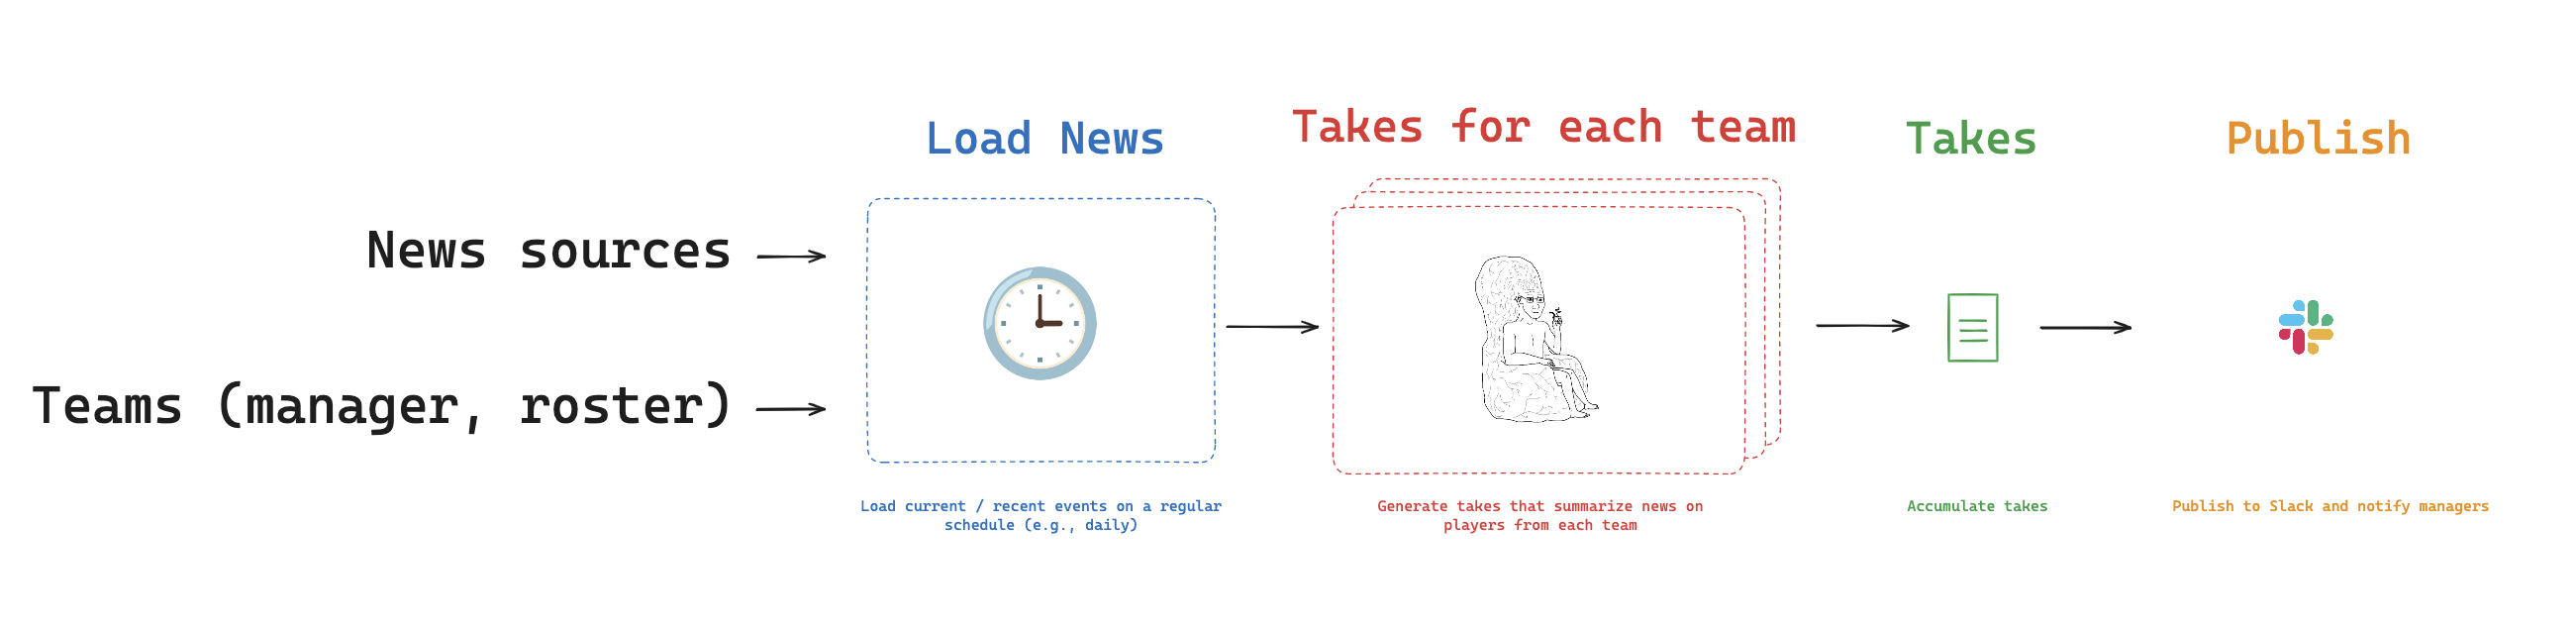

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai langchain-anthropic espn_api praw 

In [20]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [21]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ff-take-bot"

## Data sources

### ESPN Fantasy

Follow README to set env vars.

In [22]:
import os
from espn_api.football import League

# Acess
ESPN_LEAGUE_ID = os.getenv('ESPN_LEAGUE_ID')
ESPN_S2 = os.getenv('ESPN_S2')
ESPN_SWID = os.getenv('ESPN_SWID')

# Hard code this once mapping from teams to Slack handles
teams = ['Milwaukee Bucks',
 'Hallucinations of Nick Saban',
 "Lance's Hit Squad",
 "Harrison's Team",
 'The Tank Bigsbies',
 'Taylor-Augmented Termination',
 'Rookie Season',
 'Mookillem',
 'This is the Wei',
 "Brace's Best Lineup"]

slack_handles = [
    "@Eric Han",
    "@Ben Mangum",
    "@lance",
    "@Harrison Chase",
    "@Sam Noyes",
    "@Jacob Lee",
    "@Maddy",
    "@Mukil Loganathan",
    "@Wei Wong",
    "@Brace Sproul",
]

TEAM_TO_SLACK = {team: handle for team, handle in zip(teams, slack_handles)}

### Reddit

Follow README to set env vars.

In [23]:
import praw

# Reddit creds
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Fantasy Football Loader')

def get_recent_reddit_posts(subreddit_name,
                            filter_to_use,
                            number_of_posts,
                            number_of_comments,
                           ):

    """
    Retrieve top posts and their comments from a specified subreddit.

    Args:
    subreddit_name (str): Name of the subreddit to fetch posts from.
    filter_to_use (str): Time filter for top posts (e.g., 'day', 'week', 'month', 'year', 'all').
    number_of_posts (int): Number of top posts to retrieve.
    number_of_comments (int): Number of top comments to fetch for each post.

    Returns:
    str: A formatted string containing information about the top posts and their comments.
         Each post entry includes:
         - Post title
         - Post URL
         - Post score
         - Top comments (up to the specified number) with their scores
         Posts are separated by a line of '=' characters.

    Note:
    This function requires a properly initialized 'reddit' object with necessary permissions.
    """

    # Access the subreddit
    subreddit = reddit.subreddit(subreddit_name)
    
    # Get top posts based on the specified filter
    top_posts = subreddit.top(time_filter=filter_to_use, limit=number_of_posts)
    
    # Initialize an empty string to store the output
    reddit_expert_context = ""
    
    # Process each post
    for post in top_posts:
        reddit_expert_context += f"Title: {post.title}\n"
        reddit_expert_context += f"Source Data URL: {post.url}\n"
        reddit_expert_context += f"Reddit Post URL: {post.shortlink}\n"
        reddit_expert_context += f"Score: {post.score}\n"
        
        post.comments.replace_more(limit=0)  # Flatten the comment tree
        
        # Get the specified number of top comments
        for i, comment in enumerate(post.comments[:number_of_comments]):
            reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
            reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

Version 7.8.0 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


## Build graph

### Parameters and LLM

We created Slack webhook to a channel for notification

In [1]:
import os
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic 

# LLM
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 
take_bot_url = os.getenv('TAKE_BOT_SLACK_URL')

### State

State for the graph

In [24]:
import operator
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, List, Annotated

class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take",
    )
    take: str = Field(
        description="Fun, punchy observation about a specific player",
    )
    source_url: str = Field(
        description="Source data URL for information in the take (if applicable)",
    )
    reddit_url: str = Field(
        description="Reddit post URL for the post",
    )
    reasoning: str = Field(
        description="Provide your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

class TakeGeneratorOutputState(TypedDict):
    takes: List[Take]

class TakeGeneratorState(TypedDict):
    team: dict
    context: str
    takes: List[Take]

class OverallState(TypedDict):
    league: List[dict]
    context: str
    takes: Annotated[List[Take], operator.add]

### Graph

We generate takes per team and `write_to_slack` as [blocks](https://app.slack.com/block-kit-builder/T04F8K3FZB5#%7B%22blocks%22:%5B%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22Hello,%20Assistant%20to%20the%20Regional%20Manager%20Dwight!%20*Michael%20Scott*%20wants%20to%20know%20where%20you'd%20like%20to%20take%20the%20Paper%20Company%20investors%20to%20dinner%20tonight.%5Cn%5Cn%20*Please%20select%20a%20restaurant:*%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Farmhouse%20Thai%20Cuisine*%5Cn:star::star::star::star:%201528%20reviews%5Cn%20They%20do%20have%20some%20vegan%20options,%20like%20the%20roti%20and%20curry,%20plus%20they%20have%20a%20ton%20of%20salad%20stuff%20and%20noodles%20can%20be%20ordered%20without%20meat!!%20They%20have%20something%20for%20everyone%20here%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media3.fl.yelpcdn.com/bphoto/c7ed05m9lC2EmA3Aruue7A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Kin%20Khao*%5Cn:star::star::star::star:%201638%20reviews%5Cn%20The%20sticky%20rice%20also%20goes%20wonderfully%20with%20the%20caramelized%20pork%20belly,%20which%20is%20absolutely%20melt-in-your-mouth%20and%20so%20soft.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/korel-1YjNtFtJlMTaC26A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Ler%20Ros*%5Cn:star::star::star::star:%202082%20reviews%5Cn%20I%20would%20really%20recommend%20the%20%20Yum%20Koh%20Moo%20Yang%20-%20Spicy%20lime%20dressing%20and%20roasted%20quick%20marinated%20pork%20shoulder,%20basil%20leaves,%20chili%20&%20rice%20powder.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/DawwNigKJ2ckPeDeDM7jAg/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22actions%22,%22elements%22:%5B%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Farmhouse%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Kin%20Khao%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Ler%20Ros%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D%5D%7D%5D%7D). 

We'll add a breakpoint before it to ensure that we want to write! 

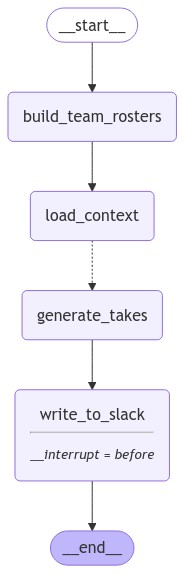

In [25]:
import requests

from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START

from IPython.display import Image, display

def build_team_rosters(state: OverallState):
    """
    Build a list of team rosters with associated Slack handles.

    Args:
    teams (list): A list of Team objects from the ESPN API.
    team_to_slack (dict): A dictionary mapping team names to Slack handles.

    Returns:
    list: A list of dictionaries, each containing a team's Slack handle and list of players.
    Each dictionary has the format:
    {
        "slack_handle": str,
        "players": list[str]
    }
    """
    # Get league data
    league = League(league_id=ESPN_LEAGUE_ID, 
                    year=2024, 
                    espn_s2=ESPN_S2, 
                    swid=ESPN_SWID)

    # Slack handle -> roster mapping
    teams = league.teams

    roster_list = []
    
    for team in teams:
        team_name = team.team_name
        slack_handle = TEAM_TO_SLACK.get(team_name, "Unknown")
        
        players = [player.name for player in team.roster]
        
        roster_dict = {
            "slack_handle": slack_handle,
            "players": players
        }
        
        roster_list.append(roster_dict)
    
    return {"league": roster_list}

def load_context(state: OverallState):
    """ Generate context from Reddit """
    
    # Replace with the subreddit you're interested in
    subreddit_name = 'fantasyfootball'
    
    # Get top comments from past <day, month, etc>
    filter_to_use = 'day'
    
    # Number of posts to gather
    number_of_posts = 20
    
    # Number of top comments to gather per post
    number_of_comments = 3

    # Pull recent posts 
    reddit_recent_posts = get_recent_reddit_posts(subreddit_name,
                                                  filter_to_use,
                                                  number_of_posts,
                                                  number_of_comments)

    return {"context": reddit_recent_posts}

take_instructions="""Your job is to generate fun, punchy takes for a Fantasy Football manager about the players on his / her team.

Carefully review and memorize the list of players on the manager's team provided by the manager at the end of these instructions. 

This list of players is definitive and should be used as the sole reference for the manager's team composition.

Examine the recent news and events in the world of the NFL provided below.

For each news item, systematically cross-reference it against the memorized list of the manager's players. 

IMPORTANT: Only generate takes for players who are EXPLICITLY and DIRECTLY mentioned by name in the news items. Do not infer, extrapolate, or generate takes based on indirect implications or general trends that might affect a player.

If and only if a news item specifically mentions a player by name, and that player is on the manager's team, generate a take about that player.

Each take should be player-specific and based solely on the provided news. Do not include speculation or information from outside the given news items.

Create a numbered list of takes and format each take as follows:

Include a concise and fun subject line
Start with "Hey {manager}:" and then provide a brief summary of the news, focusing only on what is directly stated about the player
Include the exact Source URL of the news item, if provided
Include the exact Reddit post URL of the news item
Provide your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager

After generating each take, double-check that the player mentioned is indeed on the manager's team by referring back to the original list.

If no news items directly mention any players on the manager's team by name, explicitly state that no relevant news was found for the team's players.

Before finalizing your response, review all generated takes and confirm once more that each mentioned player is on the manager's team as listed at the beginning of the prompt and is explicitly named in the news item.

If a player is not directly named in the news or you're unsure about whether a player is on the team, do not generate a take for that player.

Here are the recent news and events in the world of the NFL to base your takes on: {context}"""

take_format_instructions="""Your job is to review and then format a final list of fun, punchy takes for a Fantasy Football manager about the players on his / her team.

Review Phase:
1. First, check if any takes are provided in the list of takes. If the list of takesis empty or contains no takes, provide no output and end the process.

2. If there are takes provided, then carefully review and memorize the list of players on the manager's team provided at the end of these instructions. This list is definitive and should be used as the sole reference for the manager's team composition.

3. For each take in the list of takes, verify that:
   a) The player mentioned is EXPLICITLY and DIRECTLY named in the take.
   b) The player is on the manager's team (as per the provided list).
   c) The take is based solely on the information provided within the list of takes.

4. Discard any takes that do not meet ALL of the above criteria.

Here is the list of takes to review:

{context}

---

Formatting Phase:
If any takes remain after the review phase, format each take as follows:

1. Include a concise and fun subject line
2. Start the summary with "Hey {manager}:" and then provide a brief summary of the news, focusing only on what is directly stated about the player
3. Include the exact Source URL of the news item, if provided
4. Include the exact Reddit post URL of the news item
5. End with your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager

Final Check:

Before finalizing your response, review ALL formatted takes once more to ensure they meet all criteria.

Ensure that the summary of EACH formatted take starts with "Hey {manager}:".

If no takes remain after the review process, provide no output."""

def generate_takes(state: TakeGeneratorState) -> TakeGeneratorOutputState:
    """ Node to generate takes, and review / format them """

    # Get team
    team = state["team"]
    context = state["context"]

    # Get player and manager
    manager = team['slack_handle']
    players = ' // '.join(player for player in team['players'])

    # Instructions
    take_system_promot = take_instructions.format(manager=manager, context=context)
    take_human_message = "Only generate takes if any of these players are EXPLICITLY and DIRECTLY in the news. Here are the players: {players}".format(players=players)
    
    # Generate takes
    takes = llm.invoke([SystemMessage(content=take_system_promot)]+[HumanMessage(content=take_human_message)])

    # Enforce structured output
    structured_llm = llm.with_structured_output(Takes)
    take_formatting_system_promot = take_format_instructions.format(manager=manager, context=takes.content)
    take_formatting_human_message = "Only generate your final, formatted takes if any of these players are EXPLICITLY and DIRECTLY in the provided list of takes. Here are the players: {players}".format(players=players)
 
    # Generate takes
    formatted_takes = structured_llm.invoke([SystemMessage(content=take_formatting_system_promot)]+[HumanMessage(content=take_formatting_human_message)])
    
    # Write to state  
    return {"takes": [formatted_takes]}

def initiate_all_takes(state: OverallState):
    """ This is the "map" step to initiate takes per team """    

    league = state["league"]
    context = state["context"]
    return [Send("generate_takes", {"team": team,
                                    "context": context}) for team in league]

def write_to_slack(state: OverallState):
    """ Write takes to Slack """
    
    # Full set of interview reports
    takes = state["takes"]

    # Write to your Slack Channel via webhook
    true = True
    headers = {
        'Content-Type': 'application/json',
    }

    # Write to slack
    for t in takes:
        for take in t.takes:
            
            # Blocks
            blocks = []
            
            # Block 1: Title section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"*{take.title}*"
                }
            })
            
            # Block 2: Divider
            blocks.append({
                "type": "divider"
            })
            
            # Block 3: Content section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"{take.take}"
                }
            })

            # Block 4: Divider
            blocks.append({
                "type": "divider"
            })

            # Block 5: Source
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"Source: {take.source_url}" 
                }
            })

            # Block 6: Divider
            blocks.append({
                "type": "divider"
            })

            # Block 7: Reddit post
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"Reddit post: {take.reddit_url}"
                }
            })
            
            blocks.insert(0, {
                "type": "header",
                "text": {
                    "type": "plain_text",
                    "text": ":fire: :robot_face: Take-Bot is heating up ...",
                    "emoji": true
                }
            })
            
            data = {
                "blocks": blocks,
                "unfurl_links": True,
                "unfurl_media": True,
            }
            
            response = requests.post(take_bot_url, headers=headers, json=data)

# Add nodes and edges 
overall_builder = StateGraph(OverallState)

# Add nodes and edges 
overall_builder.add_node("build_team_rosters", build_team_rosters)
overall_builder.add_node("load_context", load_context)
overall_builder.add_node("generate_takes", generate_takes)
overall_builder.add_node("write_to_slack",write_to_slack)

# Flow
overall_builder.add_edge(START, "build_team_rosters")
overall_builder.add_edge("build_team_rosters", "load_context")
overall_builder.add_conditional_edges("load_context", initiate_all_takes, ["generate_takes"])
overall_builder.add_edge("generate_takes", "write_to_slack")
overall_builder.add_edge("write_to_slack", END)

# Compile
memory = MemorySaver()
graph = overall_builder.compile(interrupt_before=['write_to_slack'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
thread = {"configurable": {"thread_id": "1"}}
result = graph.invoke({"league": []}, thread)

In [27]:
from IPython.display import Markdown, display
state = graph.get_state(thread)
for takes in state.values['takes']:
    for take in takes.takes:
               display(Markdown(f"""
### {take.title}

{take.take}

**Source URL:** {take.source_url}

**Reddit URL:** {take.reddit_url}

**Reasoning:**

{take.reasoning}

---
"""))


### Mooney's Hamstring Hiccup

Hey @Eric Han: Darnell Mooney left the game with a hamstring injury and was questionable to return. The Bears were down by 32 points at the time, making his return unlikely.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1gtqyqy

**Reasoning:**

This take is relevant because Darnell Mooney is explicitly mentioned in the news and is listed on your roster. The hamstring injury could potentially impact his availability and performance in upcoming games, which is important information for your fantasy team management.

---



### Lions D/ST Roars Against Jaguars

Hey @Ben Mangum: The Lions D/ST had an incredible performance against the Jacksonville Jaguars, who allowed 46+ points and 550+ yards. This dominant showing by the Lions defense could be a great sign for your fantasy team's defensive scoring potential in upcoming matchups.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1gtuucw

**Reasoning:**

The Lions D/ST is explicitly mentioned in the take and is confirmed to be on your roster of players. This news directly relates to their performance and potential fantasy impact.

---



### Ladd McConkey's Rollercoaster Day

Hey @lance: Ladd McConkey briefly went to the medical tent after a catch but returned to the game. He's been averaging 16.5 PPG, 6 targets per game, and 87.5 receiving yards per game over the last 4 weeks.

**Source URL:** https://x.com/krisrhim1/status/1858326738805440636?s=46

**Reddit URL:** https://redd.it/1gttqeu

**Reasoning:**

Ladd McConkey is explicitly mentioned in the take and is on your roster. His recent performance metrics and brief injury scare are directly relevant to his fantasy value.

---



### Taysom Hill's Historic Performance

Hey @lance: Taysom Hill had an explosive game with 3 TDs, 138 rushing yards, 50 receiving yards, 18 passing yards, and 42 kick return yards. He's now the oldest player since the merger to have 175+ yards from scrimmage and 3 TDs in a single game.

**Source URL:** https://x.com/saints/status/1858259404681838711?s=46&t=wp8hqdL5HmeMqYA3P34MuA

**Reddit URL:** https://redd.it/1gtpe93

**Reasoning:**

Taysom Hill is explicitly mentioned in the take and is on your roster. His historic performance across multiple statistical categories makes him a unique and potentially valuable fantasy asset.

---



### Jared Goff's Offensive Explosion

Hey @lance: Jared Goff led the Lions to a massive offensive day, with the team scoring 174.78 points in ESPN PPR scoring.

**Source URL:** https://www.reddit.com/r/fantasyfootball/comments/1gtunwk/all_lions_lineup_would_score_today_17478_espn/

**Reddit URL:** https://redd.it/1gtunwk

**Reasoning:**

Jared Goff is explicitly mentioned in the take and is on your roster. As the Lions' quarterback, his role in this high-scoring performance directly impacts his fantasy value.

---



### The King's Reign Continues

Hey @Harrison Chase: Derrick Henry leads all NFL running backs with 13 rushing touchdowns this season, according to recent stats.

**Source URL:** 

**Reddit URL:** https://redd.it/1gtsirc

**Reasoning:**

Derrick Henry is explicitly mentioned in the take and is on your roster. The take directly highlights his performance this season, specifically noting that he leads all NFL running backs in rushing touchdowns. This information is valuable for fantasy managers as it underscores Henry's consistent ability to find the end zone, making him a crucial asset for your team.

---



### Brock Bowers Makes History!

Hey @Sam Noyes: Rookie TE Brock Bowers had a record-breaking game with 13 catches for 124 yards and 1 TD. This is the most catches by a rookie TE in a single game in NFL history!

**Source URL:** https://twitter.com/FieldYates/status/1858255678508597309

**Reddit URL:** https://redd.it/1gto09a

**Reasoning:**

Brock Bowers is explicitly mentioned in the take and is on your roster. This news directly highlights his exceptional performance, setting an NFL record for rookie tight ends.

---



### Jayden Daniels in the Rookie of the Year Race

Hey @Sam Noyes: In a discussion about Bo Nix's performance, it was noted that 'The way Jayden Daniels been playing lately. I think Bo nix has real chance at rookie of the year award.'

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1gtrjg9

**Reasoning:**

Jayden Daniels is explicitly mentioned in the take and is on your team. This comment suggests he's been playing well enough to be in contention for Rookie of the Year, which is significant for his fantasy value.

---



### Jameson Williams Part of Lions' Offensive Explosion

Hey @Sam Noyes: The Detroit Lions had an incredible offensive day, with an all-Lions fantasy lineup scoring 174.78 points in ESPN PPR scoring.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1gtunwk

**Reasoning:**

Jameson Williams is explicitly mentioned as part of the Lions offense and is on your team. This news about the Lions' high-scoring performance could indicate potential for Williams' future fantasy production.

---



### Jonathan Taylor's Workhorse Status

Hey @Jacob Lee: Jonathan Taylor was mentioned in a stat about running backs who saw every carry in their backfield. He and Chase Brown own 7 of the 12 games this year where a running back saw every running back carry in his backfield.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1gu7qm8

**Reasoning:**

Jonathan Taylor is explicitly mentioned in the take and is confirmed to be on your roster. This statistic highlights his importance in the Colts' running game and suggests strong fantasy potential.

---



### Josh Allen's Red Zone Efficiency

Hey @Jacob Lee: A comment about James Cook's rushing touchdowns indirectly mentioned Josh Allen, stating 'This is why Josh Allen is like QB5 instead of QB1...the reverse Jalen Hurts'.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1gtsirc

**Reasoning:**

Josh Allen is explicitly mentioned in the take and is confirmed to be on your roster. This comment suggests that the Bills' red zone efficiency with running backs might be impacting Allen's fantasy production.

---



### David Montgomery's Stellar Performance

Hey @Jacob Lee: In a discussion about the Lions' offensive explosion, David Montgomery was specifically mentioned as a draft steal, providing consistent RB2 numbers with potential for RB1 production.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1gtunwk

**Reasoning:**

David Montgomery is explicitly mentioned in the take and is confirmed to be on your roster. This news reinforces his value in the potent Lions offense and suggests he's a reliable fantasy asset for your team.

---



### Sun God Shines Bright!

Hey @Maddy: Amon-Ra St. Brown had a monster game against the Jacksonville Jaguars, catching all 11 targets for 161 yards and 2 touchdowns, totaling 38.7 PPR points. This marks his 8th straight game of the season with at least one touchdown.

**Source URL:** https://www.detroitlions.com/news/notebook-st-brown-extends-touchdown-streak-to-8-games

**Reddit URL:** https://redd.it/1gtu18a

**Reasoning:**

Amon-Ra St. Brown is explicitly listed on your team roster, and this news directly relates to his outstanding performance in the recent game.

---



### Bo Knows Football!

Hey @Maddy: Broncos rookie QB Bo Nix had an impressive outing against the Falcons, completing 28 of 33 passes for 307 yards, 4 TDs, 0 INTs, and a 145.0 passer rating.

**Source URL:** https://x.com/MySportsUpdate/status/1858296241815253469

**Reddit URL:** https://redd.it/1gtrjg9

**Reasoning:**

Bo Nix is explicitly listed on your team roster, and this news directly relates to his stellar performance in the recent game.

---



### Evans Back in Action

Hey @Maddy: Mike Evans has returned to practice for the Buccaneers, potentially gearing up for a strong finish to the season.

**Source URL:** https://bucsreport.com/2024/11/18/buccaneers-mike-evans-returns-to-practice-2/amp/

**Reddit URL:** https://redd.it/1gubhgd

**Reasoning:**

Mike Evans is explicitly listed on your team roster, and this news directly relates to his return to practice after an injury.

---



### James Cook's Touchdown Tally

Hey @Mukil Loganathan: James Cook is tied for second among RBs with 10 rushing touchdowns this season, behind only Derrick Henry's 13.

**Source URL:** https://x.com/SneakyJoeSports/status/1858275187793228159

**Reddit URL:** https://redd.it/1gtsirc

**Reasoning:**

This take is relevant because James Cook is explicitly mentioned in the news item and is on your roster. His impressive touchdown count puts him near the top of the league for running backs, which is significant for your fantasy team.

---



### Chase Brown: The Bengals' New Bell Cow?

Hey @Wei Wong: Chase Brown has seen 100% of Cincinnati's running back rushes for the third straight week. He and Jonathan Taylor are the only RBs to have 7 of the 12 games this year where a running back saw every running back carry in his backfield.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1gu7qm8

**Reasoning:**

This take is directly relevant to your team as Chase Brown is listed as one of your players. His increasing usage and consistent workload make him a potentially valuable asset for your fantasy team.

---



### Rookie RB Ready to Roll

Hey @Brace Sproul: Panthers rookie RB Jonathon Brooks is expected to make his NFL debut Sunday against the Chiefs, according to head coach Dave Canales.

**Source URL:** https://x.com/adamschefter/status/1858558979330207830?s=46&t=iEtr2qoWuMip-T3A0_se5Q

**Reddit URL:** https://redd.it/1gu9u3u

**Reasoning:**

This take is directly relevant to your team as Jonathon Brooks is listed on your roster. It's exciting news that the rookie is set to make his NFL debut, although it's against a tough opponent. This development could potentially impact Brooks' fantasy value for the rest of the season, making it important for you to monitor his usage and performance in this game.

---


Update state, if needed. 
 
`TODO:` we're using the `operator.add` reducer on `takes`. This only adds, but need ability to remove.

Now, let's confirm the next node to call.

In [38]:
print(state.next)

('write_to_slack',)


Now, let's write to Slack.

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

We can look at the trace:

https://smith.langchain.com/public/20aaf460-2c69-4aea-b3a6-8fb7a1b07986/r

## Setting Up A Cron

If you have a deployment (e.g., [locally or via LangGraph Cloud](https://langchain-ai.github.io/langgraph/concepts/deployment_options/)), you can [use the SDK to create a cron job](https://langchain-ai.github.io/langgraph/cloud/how-tos/cron_jobs/).

In [3]:
%%capture --no-stderr
%pip install --quiet -U langgraph_sdk

In [32]:
from langgraph_sdk import get_client

# URL from our LangGraph Cloud deployment
deployed_url = "https://ff-take-bot-deployment-f4901b2dbda85d9787dac18e2a977956.default.us.langgraph.app"
client = get_client(url=deployed_url)

In [43]:
# An assistant ID is automatically created for each deployment
await client.assistants.search(metadata={"created_by": "system"})

[{'assistant_id': '32d71a31-0aa9-5eed-9cbc-cbb548e105da',
  'graph_id': 'take_bot',
  'created_at': '2024-11-15T00:44:32.338489+00:00',
  'updated_at': '2024-11-15T00:44:32.338489+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'take_bot'}]

In [41]:
# Use the default assistant ID
assistant_id = '32d71a31-0aa9-5eed-9cbc-cbb548e105da'

# Use she SDK to schedule a cron job to run at 1:00 PM PST (21:00 UTC) every day
cron_job_stateless = await client.crons.create(
    assistant_id,
    schedule="0 21 * * *",
    input={"league": []} 
)

In [44]:
await client.crons.search()

[{'cron_id': '1efa5ed1-ebcf-6a13-92fc-9507d46b1432',
  'assistant_id': '32d71a31-0aa9-5eed-9cbc-cbb548e105da',
  'thread_id': None,
  'user_id': '98e16850-fd4a-4695-84a7-f2af046d1ae3',
  'payload': {'input': {'league': []},
   'schedule': '0 21 * * *',
   'assistant_id': '32d71a31-0aa9-5eed-9cbc-cbb548e105da'},
  'schedule': '0 21 * * *',
  'next_run_date': '2024-11-18T21:00:00+00:00',
  'end_time': None,
  'created_at': '2024-11-18T20:38:51.331642+00:00',
  'updated_at': '2024-11-18T20:38:51.331642+00:00'}]

In [40]:
# Delete any old cron jobs 
await client.crons.delete('cron_id')


### Debugging

If you do not see takes published to Slack, check the webhook.

In [ ]:
# Test writing 
headers = {
    'Content-Type': 'application/json',
}

# Test with a simple message first
test_data = {
    "text": "Testing Slack webhook connection..."
}

response = requests.post(take_bot_url, headers=headers, json=test_data)
print(f"Response status code: {response.status_code}")
print(f"Response text: {response.text}")

Check the status code. `"no_team"` error with a 404 status code confirms that the webhook URL is invalid.

```
Response status code: 404
Response text: no_team
```

Try creating a new webhook.

In [ ]:
# Takes
state = graph.get_state(thread)
takes = state.values['takes']

In [ ]:
# Choose one team 
test_take = takes[0]
test_take.takes

In [28]:
# Test writing 
true = True
headers = {
    'Content-Type': 'application/json',
}

for take in test_take.takes:
            
    # Blocks
    blocks = []
    
    # Block 1: Title section
    blocks.append({
        "type": "section",
        "text": {
            "type": "mrkdwn",
            "text": f"*{take.title}*"
        }
    })
    
    # Block 2: Divider
    blocks.append({
        "type": "divider"
    })
    
    # Block 3: Content section
    blocks.append({
        "type": "section",
        "text": {
            "type": "mrkdwn",
            "text": f"{take.take}"
        }
    })

    # Block 4: Divider
    blocks.append({
        "type": "divider"
    })

    # Block 5: Source
    blocks.append({
        "type": "section",
        "text": {
            "type": "mrkdwn",
            "text": f"Source: {take.source_url}" 
        }
    })

    # Block 6: Divider
    blocks.append({
        "type": "divider"
    })

    # Block 7: Reddit post
    blocks.append({
        "type": "section",
        "text": {
            "type": "mrkdwn",
            "text": f"Reddit post: {take.reddit_url}"
        }
    })
    
    blocks.insert(0, {
        "type": "header",
        "text": {
            "type": "plain_text",
            "text": ":fire: :robot_face: Take-Bot is heating up ...",
            "emoji": true
        }
    })
    
    data = {
        "blocks": blocks,
        "unfurl_links": True,
        "unfurl_media": True,
    }
    
    response = requests.post(take_bot_url, headers=headers, json=data)